In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import matplotlib as mpl
pudl_engine = pudl.db_connect_pudl()
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150

In [9]:
steam_df = analysis.get_steam_ferc1_df()
fuel_df = analysis.get_fuel_ferc1_df()
steam_df = analysis.consolidate_ferc1_expns(steam_df, min_capfac=0.6, min_corr=0.5)
plants_by_primary_fuel = analysis.primary_fuel_ferc1(fuel_df, fuel_thresh=0.5)

steam_df = steam_df.merge(plants_by_primary_fuel)
steam_df['heat_rate_btu_per_kwh'] = (steam_df['total_mmbtu']*1e6) / (1000*steam_df['net_generation_mwh'])
steam_df['capacity_factor'] = steam_df['net_generation_mwh'] / (steam_df['total_capacity_mw']*8760)
coal_plants_ferc1 = steam_df[steam_df['primary_fuel']=='coal']

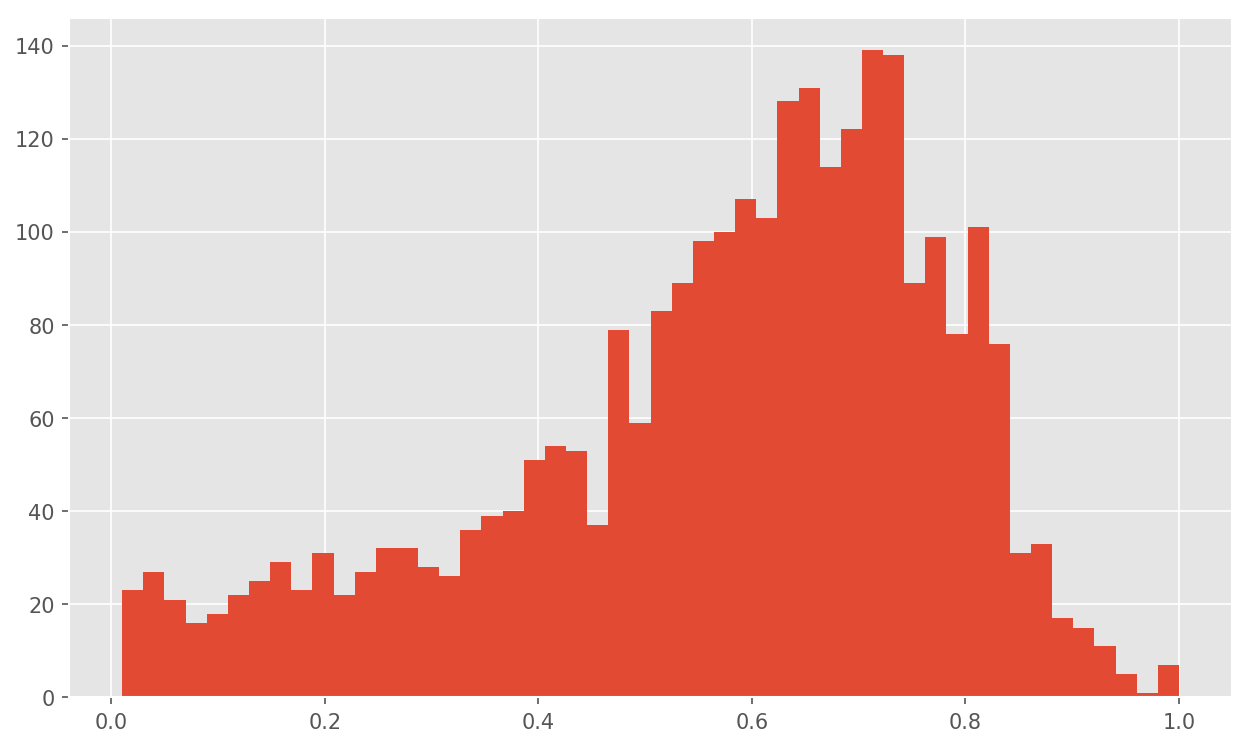

In [10]:
plt.hist(coal_plants_ferc1.capacity_factor, range=(0.01,1), bins=50);

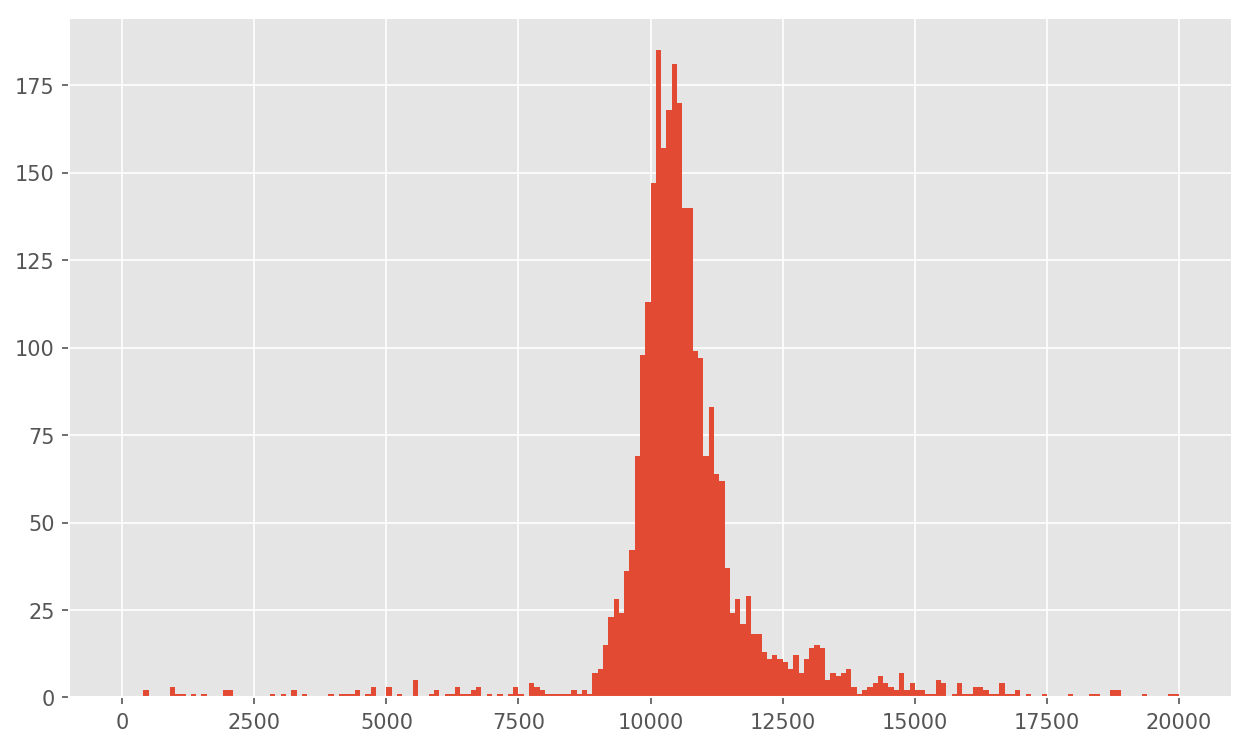

In [11]:
plt.hist(coal_plants_ferc1.heat_rate_btu_per_kwh, range=(0,20000), bins=200);

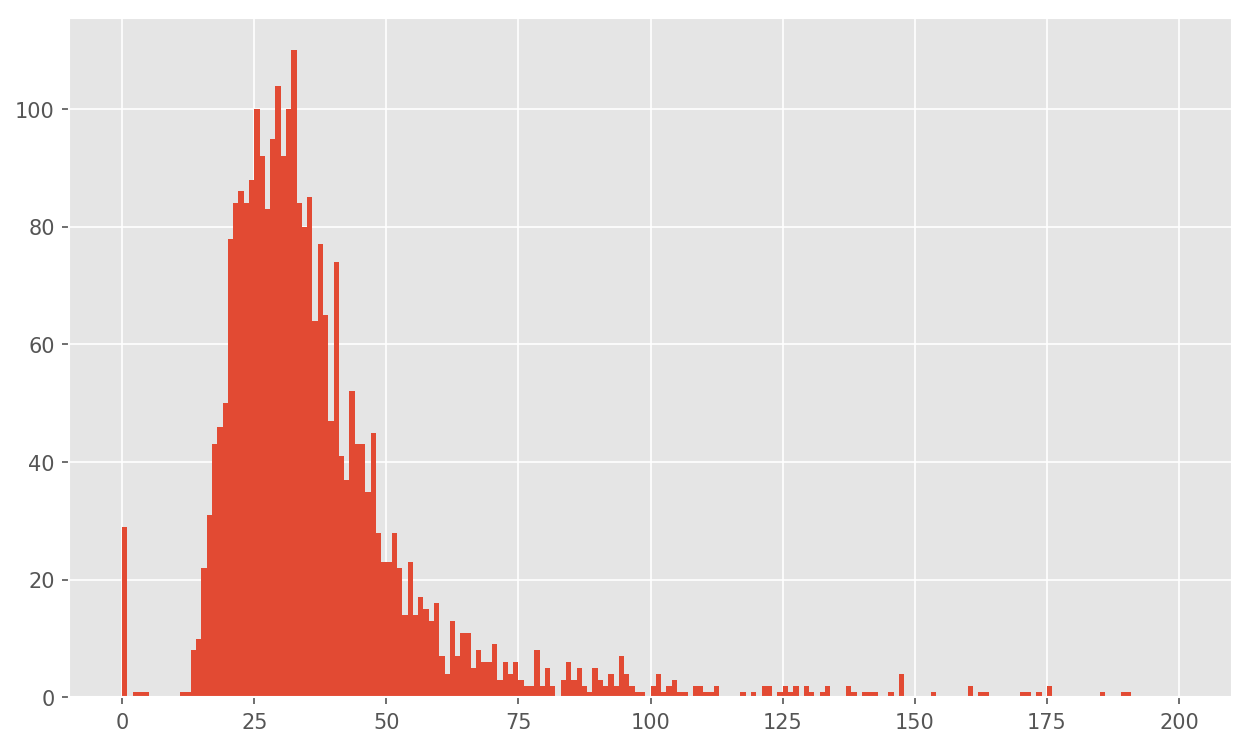

In [12]:
plt.hist(coal_plants_ferc1.expns_per_mwh, range=(0,200), bins=200);

In [50]:
pt = models.PUDLBase.metadata.tables

plants_eia923_select = sa.sql.select([
    pt['generation_fuel_eia923'],
    pt['plants_eia923'].c.plant_name,
    pt['plants_eia923'].c.plant_id_pudl
]).where(pt['generation_fuel_eia923'].c.plant_id == pt['plants_eia923'].c.plant_id)

plants_eia923 = pd.read_sql(plants_eia923_select, pudl_engine)
plants_eia923['report_date'] = pd.to_datetime(plants_eia923['report_date'])
plants_eia923.index = plants_eia923['report_date']
# groupby plant_id and by year
plants_eia923_gb = plants_eia923.groupby([pd.TimeGrouper(freq='A'), 'plant_id','plant_name','plant_id_pudl'])
# sum net_gen by year by plant and convert to dataframe
plants_eia = plants_eia923_gb.agg({'fuel_consumed_total_mmbtu' : np.sum,
                                    'net_generation_mwh' : np.sum})
plants_eia['heat_rate_btu_per_kwh'] = (plants_eia['fuel_consumed_total_mmbtu']*1000000) / (plants_eia['net_generation_mwh']*1000)
plants_eia = plants_eia.reset_index()
plants_eia['year'] = pd.DatetimeIndex(plants_eia['report_date']).year
plants_eia.drop('report_date', axis=1, inplace=True)

# Pull in the plant_eia860 table
plants_eia860_select = sa.sql.select([pt['plant_eia860'],]) # creates a sqlalchemy select object
plants_eia860 = pd.read_sql(plants_eia860_select, pudl_engine) # Uses the select to populate a DataFrame

eia860_cols = [
    'operator_id',
    'operator_name',
    'plant_id',
    'state',
    'grid_voltage_kv',
    'grid_voltage_2_kv',
    'grid_voltage_3_kv',
    'year'
]
plants_eia860 = plants_eia860[eia860_cols].copy()
plants_eia = plants_eia.merge(plants_eia860, on=['plant_id','year'])

frc_tbl = models.PUDLBase.metadata.tables['fuel_receipts_costs_eia923']
frc_select = sa.sql.select([frc_tbl.c.plant_id,
                           frc_tbl.c.report_date,
                           frc_tbl.c.fuel_quantity,
                           frc_tbl.c.average_heat_content,
                           frc_tbl.c.fuel_cost
                          ])
frc_df = pd.read_sql(frc_select, pudl_engine)
frc_df = frc_df.dropna()
frc_df['fuel_cost'] = frc_df['fuel_cost'] / 100.0
frc_df['total_fuel_cost'] = frc_df.fuel_quantity * frc_df.average_heat_content * frc_df.fuel_cost

frc_df['report_date'] = pd.to_datetime(frc_df['report_date'])
frc_df.index = frc_df['report_date']
frc_gb = frc_df.groupby([pd.TimeGrouper(freq='A'), 'plant_id'])

frc_agg = frc_gb.agg({'total_fuel_cost' : np.sum})
frc_agg = frc_agg.reset_index()
frc_agg['year'] = pd.DatetimeIndex(frc_agg['report_date']).year
frc_agg.drop('report_date',axis=1,inplace=True)

plants_eia = plants_eia.merge(frc_agg, on=['year','plant_id'])

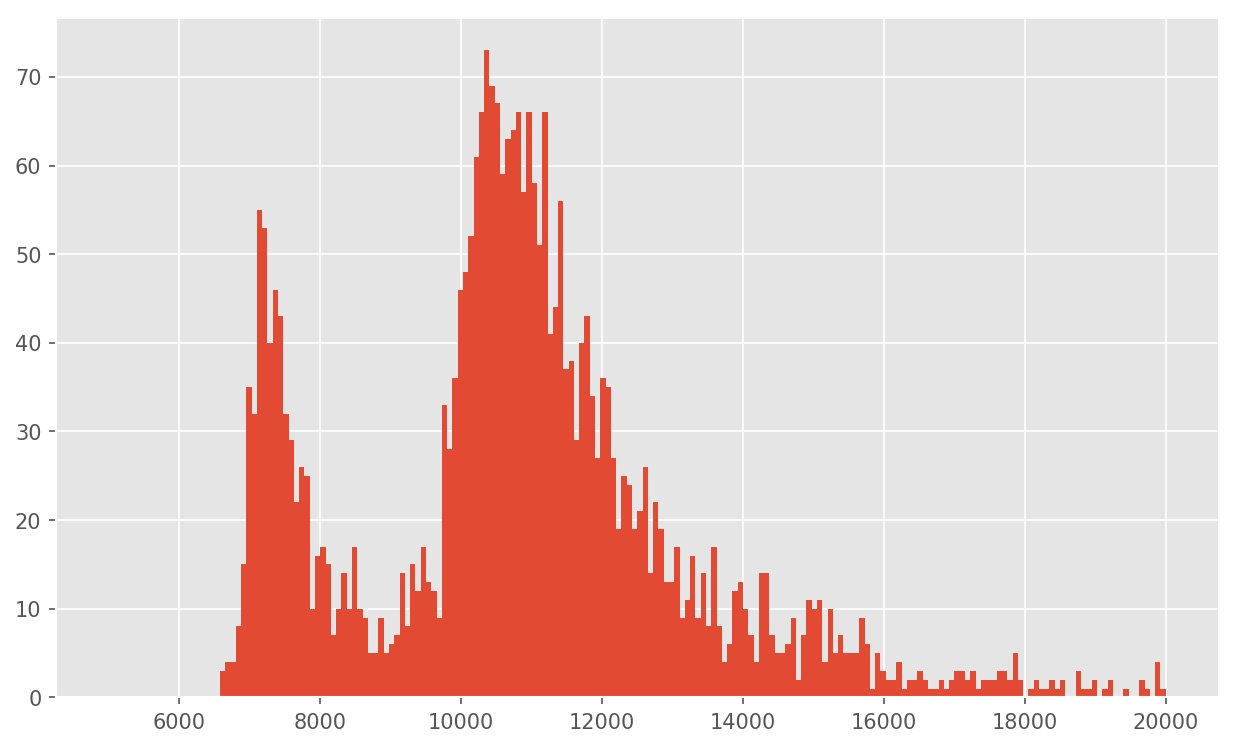

In [51]:
plt.hist(plants_eia.heat_rate_btu_per_kwh, range=(5e3,2e4), bins=200);

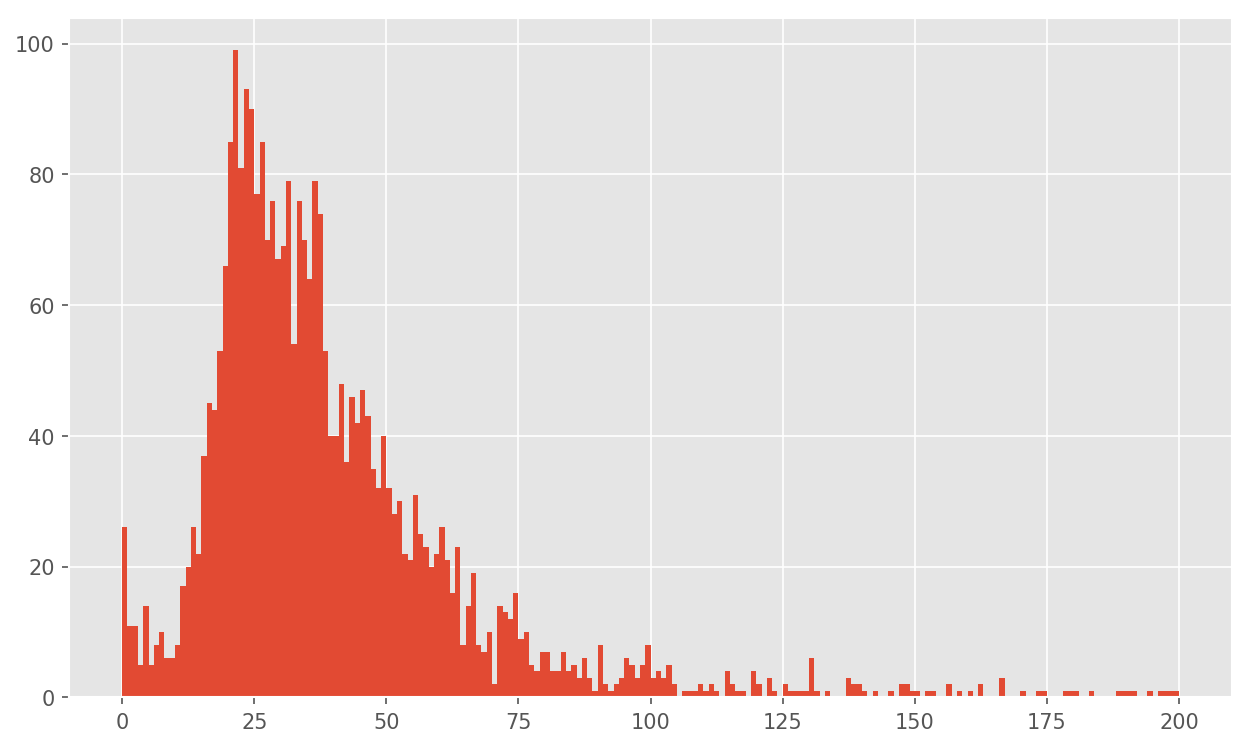

In [52]:
plt.hist(plants_eia.total_fuel_cost / plants_eia.net_generation_mwh, range=(0,200), bins=200);

In [56]:
ferc_annotations = pd.read_csv('ferc1_field_annotations.csv')
eia_annotations = pd.read_csv('eia_field_annotations.csv')
xlsx_writer = pd.ExcelWriter('plant_info_for_ce.xlsx')
coal_plants_ferc1.to_excel(xlsx_writer, sheet_name='FERC Coal Plants', index=False)
ferc_annotations.to_excel(xlsx_writer, sheet_name='FERC Annotations', index=False)
plants_eia.to_excel(xlsx_writer, sheet_name='EIA Coal Plants', index=False)
eia_annotations.to_excel(xlsx_writer, sheet_name='EIA Annotations', index=False)
xlsx_writer.save()

In [54]:
for f in plants_eia.columns:
    print(f)

plant_id
plant_name
plant_id_pudl
fuel_consumed_total_mmbtu
net_generation_mwh
heat_rate_btu_per_kwh
year
operator_id
operator_name
state
grid_voltage_kv
grid_voltage_2_kv
grid_voltage_3_kv
total_fuel_cost
